In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install nibabel

In [3]:
# In a Jupyter notebook, use the following command
!pip install tifffile


In [4]:
import os
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
print(test_image_flair.max())


test_image_t1=nib.load(TRAIN_DATASET_PATH +'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH +'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH +'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH +'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

1854.603271484375
1.0
[0 1 2 4]
[0 1 2 3]


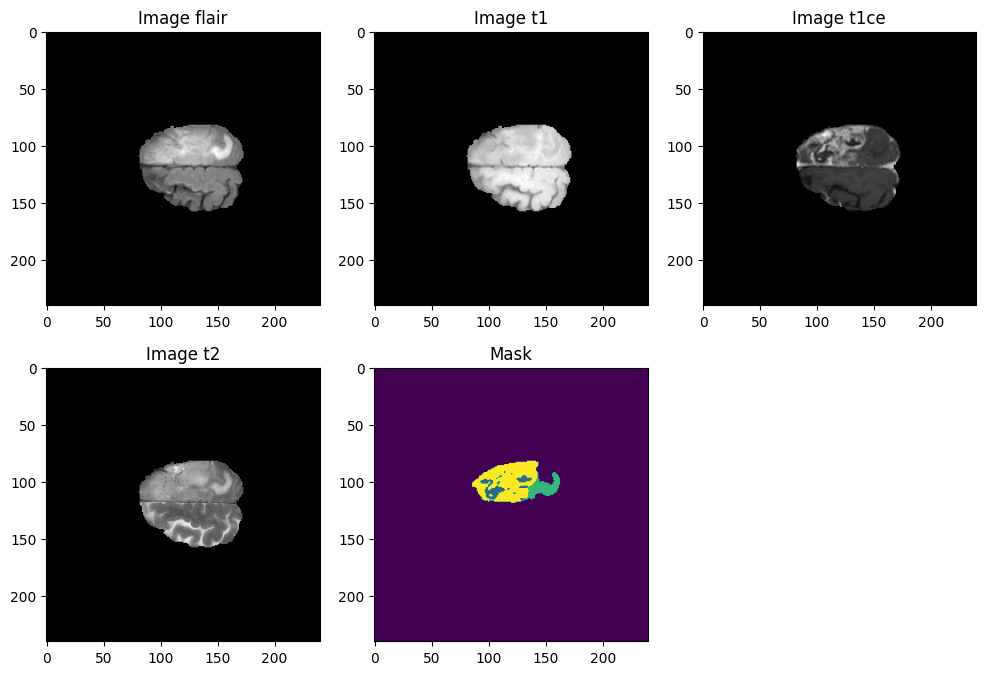

In [10]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

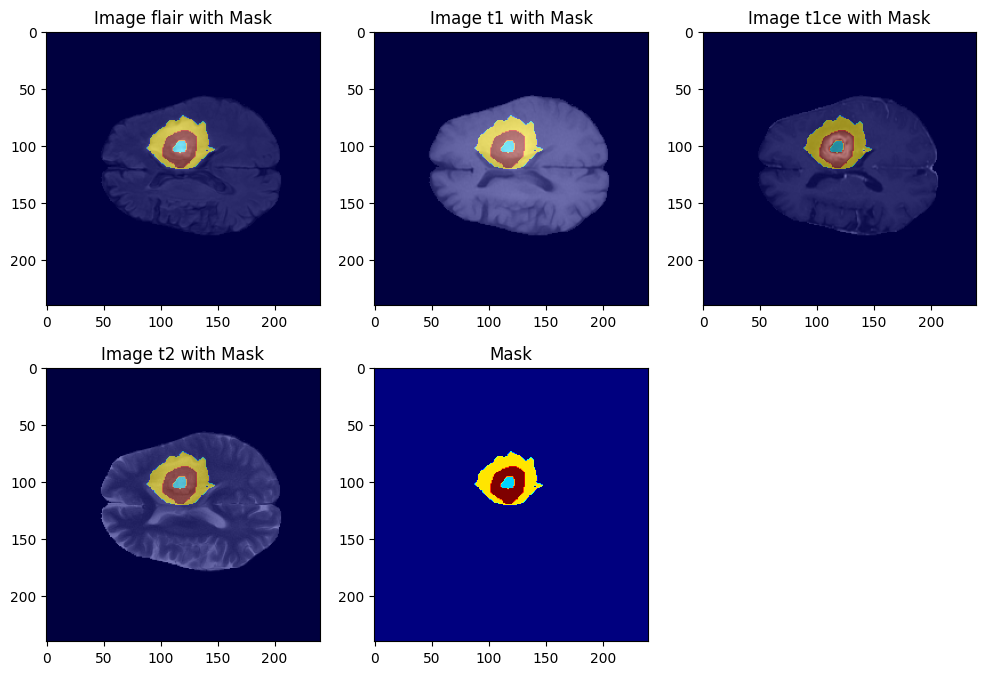

In [14]:
import random

# Choose a random slice
n_slice = random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

# Superimpose mask on Image flair
plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.imshow(test_mask[:,:,n_slice], cmap='jet', alpha=0.5)  # Overlay mask with transparency
plt.title('Image flair with Mask')

# Superimpose mask on Image t1
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.imshow(test_mask[:,:,n_slice], cmap='jet', alpha=0.5)
plt.title('Image t1 with Mask')

# Superimpose mask on Image t1ce
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.imshow(test_mask[:,:,n_slice], cmap='jet', alpha=0.5)
plt.title('Image t1ce with Mask')

# Superimpose mask on Image t2
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.imshow(test_mask[:,:,n_slice], cmap='jet', alpha=0.5)
plt.title('Image t2 with Mask')

# Only show the mask
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice], cmap='jet')
plt.title('Mask')

plt.show()


In [15]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

In [16]:
combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

In [17]:
# To get the dimensions of combined_x
combined_x_shape = combined_x.shape
print("Combined_x shape:", combined_x_shape)


Combined_x shape: (128, 128, 128, 3)


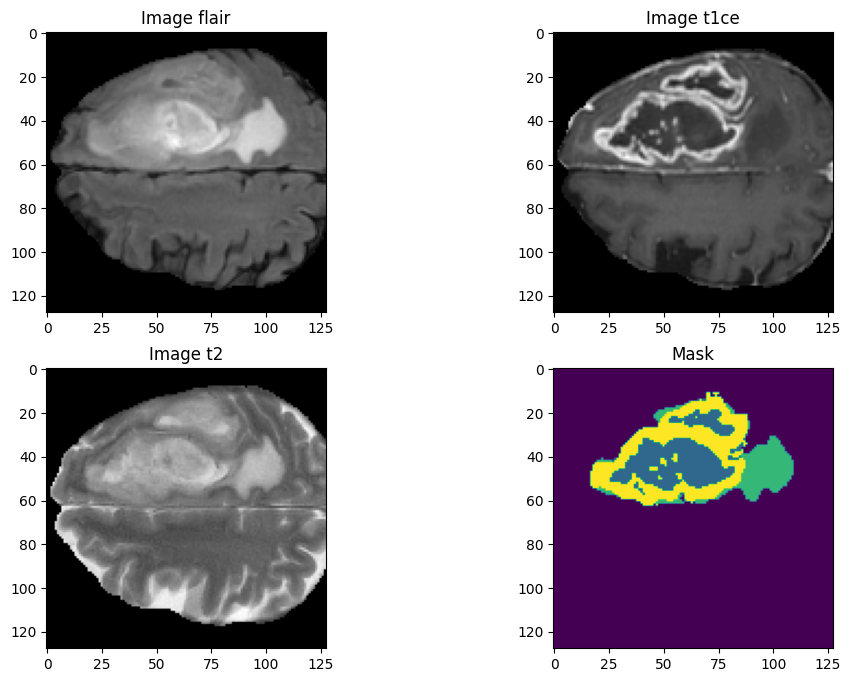

In [21]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [22]:
from pathlib import Path
import numpy as np

# Define the directory and filename
directory_path = Path('BraTS2020_TrainingData')
file_path = directory_path / 'combined355.npy'

# Ensure the directory exists, creating it if necessary
directory_path.mkdir(parents=True, exist_ok=True)

# Save the numpy array
np.save(file_path, combined_x)

print("File saved successfully at:", file_path)


File saved successfully at: BraTS2020_TrainingData\combined355.npy


In [23]:
my_img=np.load('BraTS2020_TrainingData/combined355.npy')

In [24]:
my_img_shape = my_img.shape
print("my_img shape:", my_img_shape)


my_img shape: (128, 128, 128, 3)


In [25]:
test_mask = to_categorical(test_mask, num_classes=4)

In [26]:
from pathlib import Path
import numpy as np
import nibabel as nib
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

# Ensure directory_path is defined as a Path object
directory_path = Path('BraTS2020_TrainingData')

# Ensure directories for images and masks exist
image_dir = directory_path / 'input_data_3channels/images'
mask_dir = directory_path / 'input_data_3channels/masks'
image_dir.mkdir(parents=True, exist_ok=True)
mask_dir.mkdir(parents=True, exist_ok=True)

# Initialize data lists, scaler, and unique condition example
# t2_list = [...]  # Add your list of T2 files
# t1ce_list = [...]  # Add your list of T1ce files
# flair_list = [...]  # Add your list of FLAIR files
# mask_list = [...]  # Add your list of mask files
t2_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
scaler = MinMaxScaler()

# Loop through the images
for img in range(len(t2_list)):
    print("Now preparing image and masks number:", img)

    # Load and normalize images
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    # Load and reassign mask values
    temp_mask = nib.load(mask_list[img]).get_fdata().astype(np.uint8)
    temp_mask[temp_mask == 4] = 3  # Reassign mask values from 4 to 3

    # Stack images and crop
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    # Check if the mask has at least 1% useful data
    val, counts = np.unique(temp_mask, return_counts=True)
    if (1 - (counts[0] / counts.sum())) > 0.01:  # At least 1% useful volume with non-zero labels
        print("Save Me")

        # Convert masks to categorical and save
        temp_mask = to_categorical(temp_mask, num_classes=4)

        # Construct file paths using Path and ensure they are correct
        file_path_img = image_dir / ('image_' + str(img) + '.npy')
        file_path_mask = mask_dir / ('mask_' + str(img) + '.npy')

        np.save(file_path_img, temp_combined_images)
        np.save(file_path_mask, temp_mask)

        print("Files saved successfully:")
        print("Image:", file_path_img)
        print("Mask:", file_path_mask)

    else:
        print("did not worked")



Now preparing image and masks number: 0
Save Me
Files saved successfully:
Image: BraTS2020_TrainingData\input_data_3channels\images\image_0.npy
Mask: BraTS2020_TrainingData\input_data_3channels\masks\mask_0.npy
Now preparing image and masks number: 1
Save Me
Files saved successfully:
Image: BraTS2020_TrainingData\input_data_3channels\images\image_1.npy
Mask: BraTS2020_TrainingData\input_data_3channels\masks\mask_1.npy
Now preparing image and masks number: 2
Save Me
Files saved successfully:
Image: BraTS2020_TrainingData\input_data_3channels\images\image_2.npy
Mask: BraTS2020_TrainingData\input_data_3channels\masks\mask_2.npy
Now preparing image and masks number: 3
Save Me
Files saved successfully:
Image: BraTS2020_TrainingData\input_data_3channels\images\image_3.npy
Mask: BraTS2020_TrainingData\input_data_3channels\masks\mask_3.npy
Now preparing image and masks number: 4
did not worked
Now preparing image and masks number: 5
Save Me
Files saved successfully:
Image: BraTS2020_TrainingDa

In [27]:
!pip install split_folders

In [28]:
import splitfolders  # or import split_folders

input_folder = 'BraTS2020_TrainingData/input_data_3channels/'
output_folder = 'BraTS2020_TrainingData/input_data_128/'  # Raw string to avoid escape sequences
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 688 files [23:11,  2.02s/ files]
